# Introduction

In [1]:
"""
What? Selecting dimensionality reduction with Pipeline and GridSearchCV

Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py
"""

'\nWhat? Selecting dimensionality reduction with Pipeline and GridSearchCV\n\nReference: https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py\n'

# Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
from joblib import Memory
from shutil import rmtree
# Getting rid of the warning messages
import warnings
warnings.filterwarnings("ignore")

# Modelling

In [3]:
"""
This example constructs a pipeline that does dimensionality reduction followed by prediction with a support vector
classifier. It demonstrates the use of GridSearchCV and Pipeline to optimize over different classes of estimators 
in a single CV run – unsupervised PCA and NMF dimensionality reductions are compared to univariate feature selection
during the grid search.

Additionally, Pipeline can be instantiated with the memory argument to memoize the transformers within the pipeline,
avoiding to fit again the same transformers over and over.

Note that the use of memory to enable caching becomes interesting when the fitting of a transformer is costly.
"""

'\nThis example constructs a pipeline that does dimensionality reduction followed by prediction with a support vector\nclassifier. It demonstrates the use of GridSearchCV and Pipeline to optimize over different classes of estimators \nin a single CV run – unsupervised PCA and NMF dimensionality reductions are compared to univariate feature selection\nduring the grid search.\n\nAdditionally, Pipeline can be instantiated with the memory argument to memoize the transformers within the pipeline,\navoiding to fit again the same transformers over and over.\n\nNote that the use of memory to enable caching becomes interesting when the fitting of a transformer is costly.\n'

In [4]:
pipe = Pipeline([
    # the reduce_dim stage is populated by the param_grid
    ('reduce_dim', 'passthrough'),
    ('classify', LinearSVC(dual=False, max_iter=10000))
])

N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)
X, y = load_digits(return_X_y=True)
grid.fit(X, y)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

# Plotting

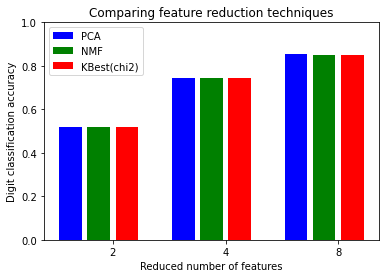

In [5]:
plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

plt.show()


# Caching transformers within a Pipeline

In [6]:
"""
It is sometimes worthwhile storing the state of a specific transformer since it could be used again. Using a
pipeline in GridSearchCV triggers such situations. Therefore, we use the argument memory to enable caching.

WARNING: Note that this example is, however, only an illustration since for this specific case fitting PCA is
not necessarily slower than loading the cache. Hence, use the memory constructor parameter when the fitting of
a transformer is costly. 
"""

'\nIt is sometimes worthwhile storing the state of a specific transformer since it could be used again. Using a\npipeline in GridSearchCV triggers such situations. Therefore, we use the argument memory to enable caching.\n\nWARNING: Note that this example is, however, only an illustration since for this specific case fitting PCA is\nnot necessarily slower than loading the cache. Hence, use the memory constructor parameter when the fitting of\na transformer is costly. \n'

In [7]:
# Create a temporary folder to store the transformers of the pipeline
location = 'cachedir'
memory = Memory(location=location, verbose=10)
cached_pipe = Pipeline([('reduce_dim', PCA()),
                        ('classify', LinearSVC(dual=False, max_iter=10000))],
                       memory=memory)

# This time, a cached pipeline will be used within the grid search


# Delete the temporary cache before exiting
memory.clear(warn=False)
rmtree(location)

In [8]:
"""
The PCA fitting is only computed at the evaluation of the first configuration of the C parameter of the LinearSVC 
classifier. The other configurations of C will trigger the loading of the cached PCA estimator data, leading to 
save processing time. Therefore, the use of caching the pipeline using memory is highly beneficial when fitting a 
transformer is costly.
"""

'\nThe PCA fitting is only computed at the evaluation of the first configuration of the C parameter of the LinearSVC \nclassifier. The other configurations of C will trigger the loading of the cached PCA estimator data, leading to \nsave processing time. Therefore, the use of caching the pipeline using memory is highly beneficial when fitting a \ntransformer is costly.\n'